In [1]:
import os
import numpy as np
import tensorflow as tf

# Settting
os.environ['CUDA_VISIBLE_DEVICES'] = '' # choose the device (GPU) here
sess_config = tf.ConfigProto(allow_soft_placement=True)
sess_config.gpu_options.allow_growth = True # Whether the GPU memory usage can grow dynamically.

In [2]:
from matplotlib.pyplot import imshow
%matplotlib inline

# Load data

In [3]:
# training and dev sets
with open('data/train.csv', 'r') as file:
    lines = file.readlines()
num = len(lines) - 1
x = np.zeros(shape=(num,784))
y = np.zeros(shape=(num))

lines = lines[1:] # ignore pixel0, pixel1,...
np.random.shuffle(lines)

for i, line in enumerate(lines[1:]):
    items = line.strip().split(',')
    y[i] = int(items[0])
    for j, val in enumerate(items[1:]):
        x[i,j] = int(val)
        
x_train = x[:40000]
y_train = y[:40000]
x_dev = x[40000:]
y_dev = y[40000:]

In [4]:
print(len(x_train))
print(len(y_train))
print(len(x_dev))
print(len(y_dev))

40000
40000
2000
2000


In [5]:
# test set
with open('data/test.csv', 'r') as file:
    lines = file.readlines()
num = len(lines) - 1
x_test = np.zeros(shape=(num,784))
for i, line in enumerate(lines[1:]):
    items = line.strip().split(',')
    for j, val in enumerate(items):
        x_test[i,j] = int(val)
        
print(len(x_test))

28000


label = 7.0


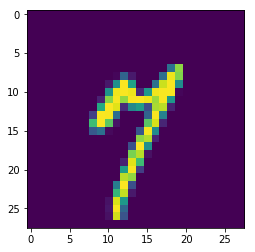

In [6]:
idx = 24
imshow(x_train[idx].reshape(28,28))
print('label =', y_train[idx])

# Neural Networks

In [11]:
# Feed-forward neural network
def build_ff_model(x):
    
    W1 = tf.get_variable("W1", [784, 250], initializer=tf.glorot_normal_initializer())
    b1 = tf.get_variable("b1", [250], initializer=tf.zeros_initializer())
    W2 = tf.get_variable("W2", [250, 10], initializer=tf.glorot_normal_initializer())
    b2 = tf.get_variable("b2", [10], initializer=tf.zeros_initializer())

    # computation
    z1 = tf.matmul(x, W1) + b1
    a1 = tf.nn.tanh(z1)

    z2 = tf.matmul(a1, W2) + b2
    nn_output = tf.nn.softmax(z2)

    return nn_output

In [12]:
# Convolutional neural network
def build_cnn_model(x):
    
    s = tf.shape(x)
    x1 = tf.reshape(x, shape=(s[0], 28, 28, 1))


    # Convolutional Layer 1
    layer_conv1, weights_conv1 = new_conv_layer(
        input=x1, num_input_channels=1, 
        filter_size=5, num_filters=6, name ="conv1")
    # RelU layer 1
    layer_relu1 = new_relu_layer(layer_conv1, name="relu1")
    # Pooling Layer 1
    layer_pool1 = new_pool_layer(layer_relu1, name="pool1")

    # Convolutional Layer 2
    layer_conv2, weights_conv2 = new_conv_layer(
        input=layer_pool1, num_input_channels=6, 
        filter_size=5, num_filters=16, name= "conv2")
    # RelU layer 2
    layer_relu2 = new_relu_layer(layer_conv2, name="relu2")
    # Pooling Layer 2
    layer_pool2 = new_pool_layer(layer_relu2, name="pool2")


    # Flatten Layer
    num_features = layer_pool2.get_shape()[1:4].num_elements()
    layer_flat = tf.reshape(layer_pool2, [-1, num_features])

    # Fully-Connected Layer 1
    layer_fc1 = new_fc_layer(layer_flat, num_inputs=num_features, num_outputs=128, name="fc1")

    # RelU layer 3
    layer_relu3 = new_relu_layer(layer_fc1, name="relu3")

    # Fully-Connected Layer 2
    layer_fc2 = new_fc_layer(input=layer_relu3, num_inputs=128, num_outputs=10, name="fc2")

    # Softmax
    nn_output = tf.nn.softmax(layer_fc2)
    
    return nn_output

# Experiments

In [17]:
def experiment(build_nn_model, batch_size, num_epochs):
    tf.reset_default_graph()

    x = tf.placeholder(tf.float32, [None, 784], name="x")
    y = tf.placeholder(tf.int32, [None], name="y")

    nn_output = build_nn_model(x)

    # loss function
    onehot = tf.one_hot(y, 10, dtype=tf.float32)
    loss = -1.0 * tf.reduce_mean( onehot * tf.log(nn_output) )

    # training op
    optimizer = tf.train.AdamOptimizer()
    train_op = optimizer.minimize(loss)

    # evaluation
    correct_pred = tf.equal(tf.argmax(nn_output, 1, output_type=tf.int32), y)
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))


#     batch_size = 1024
    train_size = len(x_train)

    # ---------------------- #
    tf.summary.scalar('loss', loss)
    tf.summary.scalar('accuracy', accuracy)
    summary_op = tf.summary.merge_all()
    # ---------------------- #

    counter = 0

    with tf.Session(config=sess_config) as sess:
        # writer
        summary_writer = tf.summary.FileWriter('mnist_logs/', graph_def=sess.graph_def)

        sess.run(tf.global_variables_initializer())
        for epoch in range(num_epochs):
            for i in range(int(train_size/batch_size)):
                feed_dict = {x: x_train[i*batch_size:(i+1)*batch_size],
                             y: y_train[i*batch_size:(i+1)*batch_size]}
                train_loss, _ = sess.run([loss, train_op], feed_dict=feed_dict)
                if i % 10 == 0:

                     # write something
                     summary_str = sess.run(summary_op, feed_dict=feed_dict)
                     summary_writer.add_summary(summary_str, counter)
                     counter += 1

            feed_dict = {x: x_dev, y: y_dev}
            [acc] = sess.run([accuracy], feed_dict=feed_dict)
            print("epoch: {} --- accuracy: {}".format(epoch, acc*100))


        feed_dict = {x: x_test}
        [outputs] = sess.run([nn_output], feed_dict=feed_dict)
        
        y_preds = np.argmax(outputs, axis=1)
        return y_preds

In [15]:
y_ff_preds = experiment(build_ff_model, batch_size=512, num_epochs=20)

epoch: 0 --- accuracy: 90.04999995231628
epoch: 1 --- accuracy: 90.70000052452087
epoch: 2 --- accuracy: 92.40000247955322
epoch: 3 --- accuracy: 92.5499975681305
epoch: 4 --- accuracy: 93.09999942779541
epoch: 5 --- accuracy: 92.84999966621399
epoch: 6 --- accuracy: 93.04999709129333
epoch: 7 --- accuracy: 93.34999918937683
epoch: 8 --- accuracy: 93.4000015258789
epoch: 9 --- accuracy: 93.30000281333923
epoch: 10 --- accuracy: 93.30000281333923
epoch: 11 --- accuracy: 94.45000290870667
epoch: 12 --- accuracy: 94.24999952316284
epoch: 13 --- accuracy: 93.90000104904175
epoch: 14 --- accuracy: 94.24999952316284
epoch: 15 --- accuracy: 94.15000081062317
epoch: 16 --- accuracy: 93.99999976158142
epoch: 17 --- accuracy: 94.15000081062317
epoch: 18 --- accuracy: 94.49999928474426
epoch: 19 --- accuracy: 93.80000233650208


In [14]:
y_cnn_preds = experiment(build_cnn_model, batch_size=512, num_epochs=20)

epoch: 0 --- accuracy: 93.84999871253967
epoch: 1 --- accuracy: 96.29999995231628
epoch: 2 --- accuracy: 96.8999981880188
epoch: 3 --- accuracy: 97.45000004768372
epoch: 4 --- accuracy: 97.60000109672546
epoch: 5 --- accuracy: 97.75000214576721
epoch: 6 --- accuracy: 97.85000085830688
epoch: 7 --- accuracy: 98.00000190734863
epoch: 8 --- accuracy: 98.19999933242798
epoch: 9 --- accuracy: 98.04999828338623
epoch: 10 --- accuracy: 97.89999723434448
epoch: 11 --- accuracy: 97.75000214576721
epoch: 12 --- accuracy: 98.00000190734863
epoch: 13 --- accuracy: 97.89999723434448
epoch: 14 --- accuracy: 98.19999933242798
epoch: 15 --- accuracy: 98.1000006198883
epoch: 16 --- accuracy: 98.1000006198883
epoch: 17 --- accuracy: 98.29999804496765
epoch: 18 --- accuracy: 98.25000166893005
epoch: 19 --- accuracy: 9.449999779462814


TypeError: 'NoneType' object is not subscriptable

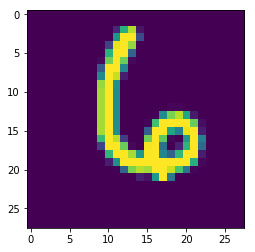

In [16]:
idx = 88
imshow(x_test[idx].reshape(28,28))
print('label =', y_cnn_preds[idx])

# Utils: CNN definition
credit: https://medium.com/data-science-group-iitr/building-a-convolutional-neural-network-in-python-with-tensorflow-d251c3ca8117

In [7]:
def new_conv_layer(input, num_input_channels, filter_size, num_filters, name):
    with tf.variable_scope(name) as scope:
        # shape of the filter-weights for the convolution
        shape = [filter_size, filter_size, num_input_channels, num_filters]

        # Create new weights (filters) with the given shape
        weights = tf.Variable(tf.truncated_normal(shape, stddev=0.05))

        # Create new biases, one for each filter
        biases = tf.Variable(tf.constant(0.05, shape=[num_filters]))

        # TensorFlow operation for convolution
        layer = tf.nn.conv2d(input=input, filter=weights, strides=[1, 1, 1, 1], padding='SAME')

        # Add the biases to the results of the convolution.
        layer += biases
        
        return layer, weights

In [8]:
def new_relu_layer(input, name):
    
    with tf.variable_scope(name) as scope:
        # TensorFlow operation for convolution
        layer = tf.nn.relu(input)
        
        return layer

In [9]:
def new_pool_layer(input, name):
    
    with tf.variable_scope(name) as scope:
        # TensorFlow operation for convolution
        layer = tf.nn.max_pool(value=input, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        return layer

In [10]:
def new_fc_layer(input, num_inputs, num_outputs, name):
    
    with tf.variable_scope(name) as scope:

        # Create new weights and biases.
        weights = tf.Variable(tf.truncated_normal([num_inputs, num_outputs], stddev=0.05))
        biases = tf.Variable(tf.constant(0.05, shape=[num_outputs]))
        
        # Multiply the input and weights, and then add the bias-values.
        layer = tf.matmul(input, weights) + biases
        
        return layer